### Initialize SDK client

With the new SDK you now only need to initialize a client with your API key.

In [1]:
from google import genai
from google.genai import types
import os
from dotenv import load_dotenv
load_dotenv()


client = genai.Client(api_key=os.getenv("gemini_api"))

### Select and configure a model

Spatial understanding works best [Gemini 2.0 Flash model](https://ai.google.dev/gemini-api/docs/models/gemini-v2). It's even better with 2.5 models like `gemini-2.5-pro` but slightly slower as it's a [thinking](./Get_started_thinking.ipynb) model.

Some features, like segmentation, only works with 2.5 models.

The [Object detection](https://github.com/google-gemini/cookbook/blob/gemini-1.5-archive/examples/Object_detection.ipynb) contains good examples of what previous models were able to do.

For more information about all Gemini models, check the [documentation](https://ai.google.dev/gemini-api/docs/models/gemini) for extended information on each of them.

In [2]:
model_name = "gemini-2.5-flash-lite" # @param ["gemini-2.0-flash", "gemini-2.5-flash-lite", "gemini-2.5-flash-lite-preview-09-2025", "gemini-2.5-flash", "gemini-2.5-flash-preview-09-2025", "gemini-2.5-pro"] {"allow-input":true}

### System instructions

 With the new SDK, the `system_instructions` and the `model` parameters must be passed in all `generate_content` calls, so let's save them to not have to type them all the time.

In [3]:
bounding_box_system_instructions = """
    Return bounding boxes as a JSON array with labels. Never return masks or code fencing. Limit to 25 objects.
    If an object is present multiple times, name them according to their unique characteristic (colors, size, position, unique characteristics, etc..).
"""

The system instructions are mainly used to make the prompts shorter by not having to reapeat each time the format. They are also telling the model how to deal with similar objects which is a nice way to let it be creative.

The [Spatial understanding example](https://aistudio.google.com/starter-apps/spatial) is using a different strategy with no system instructions but a longer prompt. You can see their full prompts by clicking on the "show raw prompt" button on the right. There no optimal solution, experiment with diffrent strategies and find the one that suits your use-case the best.

It is also recommend to always disable the [thinking](./Get_started_thinking.ipynb), as so far it adds latency without improving the results.

### Import

Import all the necessary modules.

In [4]:

from PIL import Image

import io
import os
import requests
from io import BytesIO

### Utils

Some scripts will be needed to draw the bounding boxes. Of course they are just examples and you are free to just write your own.

For example the [Spatial understanding example](https://aistudio.google.com/starter-apps/spatial) from [AI Studio](https://aistudio.google.com) uses HML to render the bounding boxes. You can find its code in the [Github repo](https://github.com/google-gemini/starter-applets/tree/main/spatial).

In [8]:

def parse_json(json_output: str):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

In [26]:

import json
import random
import io
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def plot_bounding_boxes(im, bounding_boxes):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.load_default()

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json.loads(bounding_boxes)):
      # Select a color from the list
      color = colors[i % len(colors)]

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["box_2d"][0]/1000 * height)
      abs_x1 = int(bounding_box["box_2d"][1]/1000 * width)
      abs_y2 = int(bounding_box["box_2d"][2]/1000 * height)
      abs_x2 = int(bounding_box["box_2d"][3]/1000 * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
      )

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color, font=font)


### Get example images

In [11]:
import tempfile
import fitz

In [12]:
def split_pdf_to_images(pdf_path: str, dpi: int = 150) -> dict[int, str]:
    """
    Splits a PDF into individual PNG images (one per page).

    Args:
        pdf_path (str): Path to the input PDF file.
        dpi (int): Resolution in DPI for the output images. Defaults to 150.

    Returns:
        dict[int, str]: A dictionary mapping page_number -> PNG image file path.
    """
    # Create a temporary directory to store images
    output_dir = tempfile.mkdtemp(prefix="pdf_images_")

    # Open the original PDF
    doc = fitz.open(pdf_path)
    image_dict = {}

    # Iterate through each page
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        # Calculate the zoom factor based on DPI (72 is the default resolution)
        zoom = dpi / 72
        mat = fitz.Matrix(zoom, zoom)
        pix = page.get_pixmap(matrix=mat, alpha=False)

        # Construct output file path
        output_path = os.path.join(output_dir, f"page_{page_num + 1}.png")
        pix.save(output_path)

        # Store in dictionary (1-based page number)
        image_dict[page_num + 1] = output_path

    doc.close()
    return image_dict

In [28]:
pdf_path=r'Test_docs/brochure_2.pdf'
split_pdf_to_images(pdf_path)

{1: 'C:\\Users\\surya\\AppData\\Local\\Temp\\pdf_images_cflxy13k\\page_1.png',
 2: 'C:\\Users\\surya\\AppData\\Local\\Temp\\pdf_images_cflxy13k\\page_2.png',
 3: 'C:\\Users\\surya\\AppData\\Local\\Temp\\pdf_images_cflxy13k\\page_3.png',
 4: 'C:\\Users\\surya\\AppData\\Local\\Temp\\pdf_images_cflxy13k\\page_4.png',
 5: 'C:\\Users\\surya\\AppData\\Local\\Temp\\pdf_images_cflxy13k\\page_5.png',
 6: 'C:\\Users\\surya\\AppData\\Local\\Temp\\pdf_images_cflxy13k\\page_6.png',
 7: 'C:\\Users\\surya\\AppData\\Local\\Temp\\pdf_images_cflxy13k\\page_7.png',
 8: 'C:\\Users\\surya\\AppData\\Local\\Temp\\pdf_images_cflxy13k\\page_8.png',
 9: 'C:\\Users\\surya\\AppData\\Local\\Temp\\pdf_images_cflxy13k\\page_9.png',
 10: 'C:\\Users\\surya\\AppData\\Local\\Temp\\pdf_images_cflxy13k\\page_10.png',
 11: 'C:\\Users\\surya\\AppData\\Local\\Temp\\pdf_images_cflxy13k\\page_11.png'}

## Overlaying Information

Let's start by loading an image, the origami one for example:

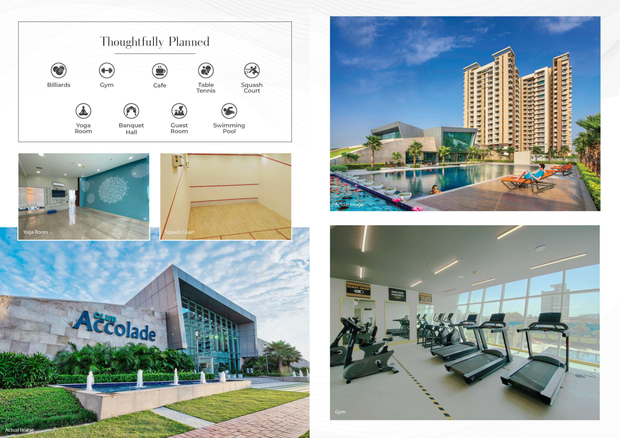

In [31]:
image ='C:\\Users\\surya\\AppData\\Local\\Temp\\pdf_images_cflxy13k\\page_3.png' # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}

im = Image.open(image)
im.thumbnail([620,620], Image.Resampling.LANCZOS)
im

Let's start with a simple prompt to find all items in the image.

To prevent the model from repeating itself, it is recommended to use a temperature over 0, in this case 0.5. Limiting the number of items (25 in the systemp instructions) is also a way to prevent the model from looping and to speed up the decoding of the bounding boxes. You can experiment with these parameters and find what works best for your use-case.

It is also recommend to always disable the [thinking](./Get_started_thinking.ipynb), as so far it adds latency without improving the results.

In [34]:
prompt = "Detect the 2d bounding boxes of Project Amenities present in it exactly cropped and labelled as the amenity category"  # @param {type:"string"}

# Load and resize image
im = Image.open(BytesIO(open(image, "rb").read()))
im.thumbnail([1024,1024], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        thinking_config=types.ThinkingConfig(
          thinking_budget=0
        )
    )
)

# Check output
print(response.text)

```json
[
  {"box_2d": [351, 258, 548, 470], "label": "Squash Court"},
  {"box_2d": [351, 30, 548, 242], "label": "Yoga Room"},
  {"box_2d": [516, 531, 959, 968], "label": "Gym"},
  {"box_2d": [37, 531, 482, 968], "label": "Swimming Pool"},
  {"box_2d": [551, 0, 1000, 500], "label": "Club Accolade"}
]
```


As you can see, even without any instructions about the format, Gemini is trained to always use this format with a label and the coordinates of the bounding box in a "box_2d" array.

Just be careful, the y coordinates are first, x ones afterwards contrary to common usage.

(1024, 724)


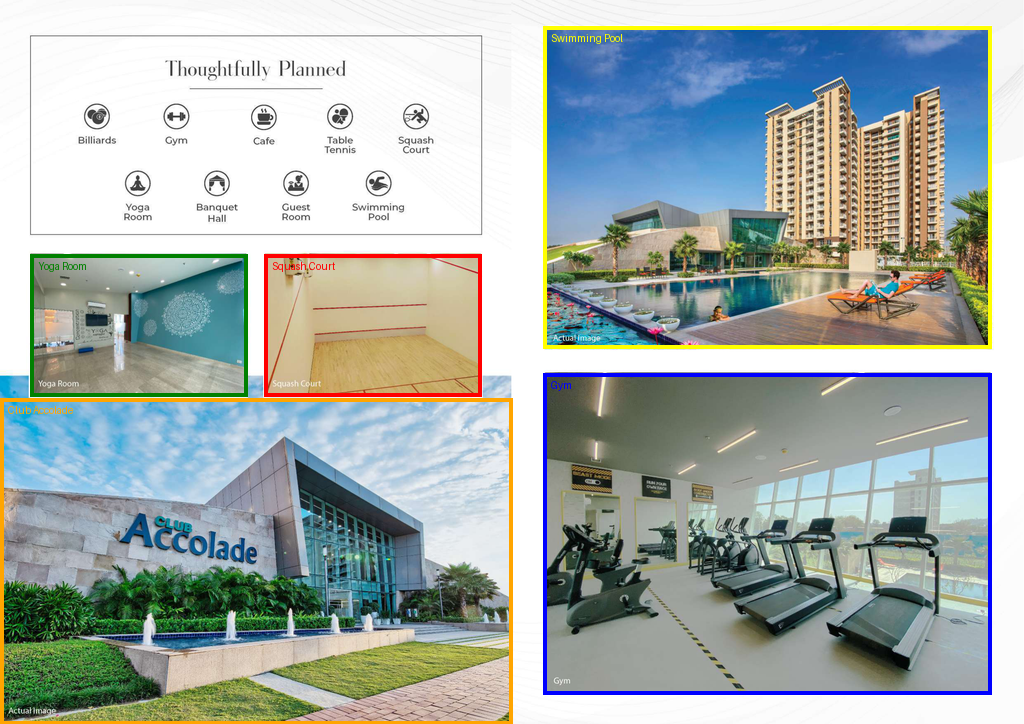

In [35]:
plot_bounding_boxes(im, response.text)
im

## Search within an image

Let's complicate things and search within the image for specific objects.

Try it with different images and prompts. Different samples are proposed but you can also write your own.

## Multilinguality

As Gemini is able to understand multiple languages, you can combine spatial reasoning with multilingual capabilities.

You can give it an image like this and prompt it to label each item with Japanese characters and English translation. The model reads the text and recognize the pictures from the image itself and translates them.

(640, 640)


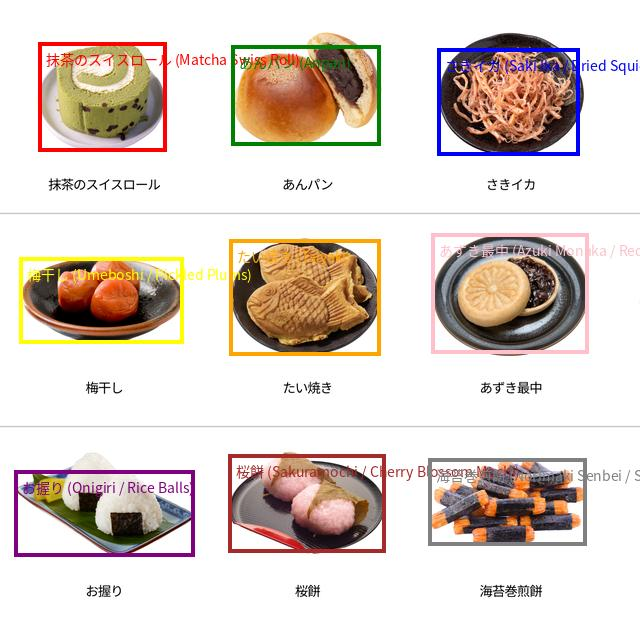

In [ ]:
image = "Japanese_bento.png" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = "Detect food, label them with Japanese characters + english translation."  # @param ["Detect food, label them with Japanese characters + english translation.", "Show me the vegan dishes","Explain what those dishes are with a 5 words description","Find the dishes with allergens and label them accordingly"] {"allow-input":true}

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
        thinking_config=types.ThinkingConfig(
          thinking_budget=0
        )
    )
)

# Generate image with bounding boxes
plot_bounding_boxes(im, response.text)
im

## Use Gemini reasoning capabilities

The model can also reason based on the image, you can ask it about the positions of items, their utility, or, like in this example, to find the shadow of a speficic item.

(640, 482)


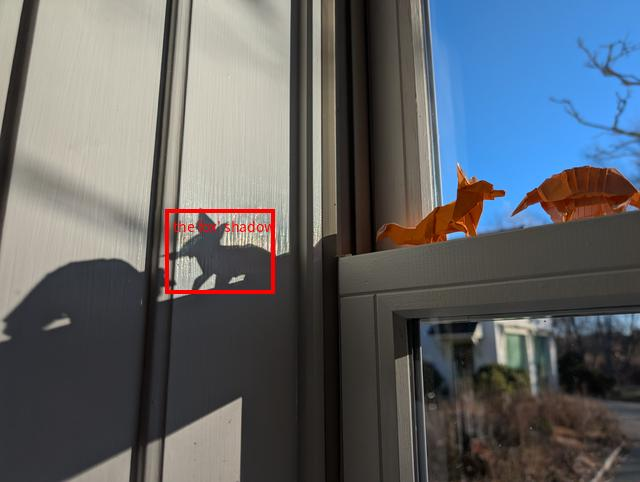

In [ ]:
image = "Origamis.jpg" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = "Draw a square around the fox' shadow"  # @param ["Find the two origami animals.", "Where are the origamis' shadows?","Draw a square around the fox' shadow"] {"allow-input":true}

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
        thinking_config=types.ThinkingConfig(
          thinking_budget=0
        )
    )
)

# Generate image with bounding boxes
plot_bounding_boxes(im, response.text)
im

You can also use Gemini knowledge to enhanced the labels returned. In this example Gemini will give you advice on how to fix your little mistake.

As you can see this time, you're only resizing the image to 1024px as it helps the model getting the bigger picture and give you advice. There's no clear rule about when to do it, experiment and find what works the best for you.

(640, 480)


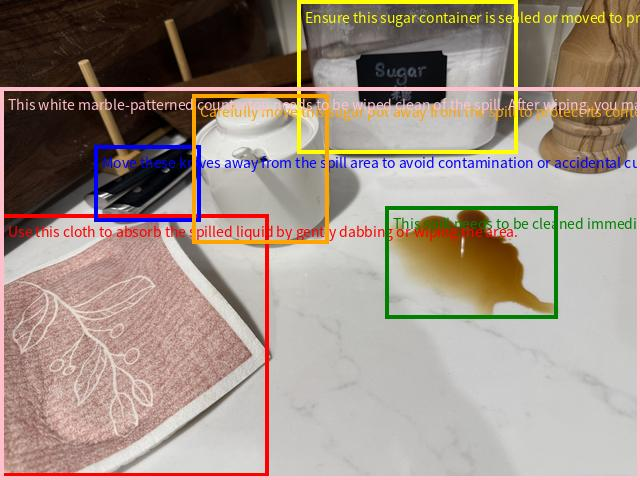

In [ ]:
image = "Spill.jpg" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = "Tell me how to clean my table with an explanation as label. Do not just label the items"  # @param ["Show me where my coffee was spilled.", "Tell me how to clean my table with an explanation as label. Do not just label the items","Draw a square around the fox' shadow"] {"allow-input":true}

# Load and resize image
im = Image.open(image)
im.thumbnail([640,640], Image.Resampling.LANCZOS)

# Run model to find bounding boxes
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        system_instruction=bounding_box_system_instructions,
        temperature=0.5,
        safety_settings=safety_settings,
        thinking_config=types.ThinkingConfig(
          thinking_budget=0
        )
    )
)

# Generate image with bounding boxes
plot_bounding_boxes(im, response.text)
im

In [ ]:
response.text

'```json\n[\n  {"box_2d": [447, 0, 992, 420], "label": "Use this cloth to absorb the spilled liquid by gently dabbing or wiping the area."},\n  {"box_2d": [431, 603, 663, 871], "label": "This spill needs to be cleaned immediately to prevent staining the countertop."},\n  {"box_2d": [303, 147, 461, 314], "label": "Move these knives away from the spill area to avoid contamination or accidental cuts during cleaning."},\n  {"box_2d": [0, 465, 320, 808], "label": "Ensure this sugar container is sealed or moved to prevent it from getting wet or contaminated during cleaning."},\n  {"box_2d": [196, 301, 508, 514], "label": "Carefully move this sugar pot away from the spill to protect its contents and prevent it from being knocked over."},\n  {"box_2d": [182, 0, 998, 1000], "label": "This white marble-patterned countertop needs to be wiped clean of the spill. After wiping, you may want to use a damp cloth to remove any residue and then dry it thoroughly."}\n]\n```'

And if you check the previous examples, the [Japanese food](#scrollTo=tvVSSr7z3uN4) one in particular, multiple other prompt samples are provided to experiment with Gemini reasoning capabilities.

## Experimental: Segmentation

2.5 models are also able to segment the image and not only draw a bounding box but to also provide a mask of the contour of the items. It's especially useful if you are planning on editing images like in the [Virtual try-on](../examples/Virtual_Try_On.ipynb) example.

In [ ]:
# @title Segmentation Utils

import dataclasses
import numpy as np
import base64

@dataclasses.dataclass(frozen=True)
class SegmentationMask:
  # bounding box pixel coordinates (not normalized)
  y0: int # in [0..height - 1]
  x0: int # in [0..width - 1]
  y1: int # in [0..height - 1]
  x1: int # in [0..width - 1]
  mask: np.array # [img_height, img_width] with values 0..255
  label: str

def parse_segmentation_masks(
    predicted_str: str, *, img_height: int, img_width: int
) -> list[SegmentationMask]:
  items = json.loads(parse_json(predicted_str))
  masks = []
  for item in items:
    raw_box = item["box_2d"]
    abs_y0 = int(item["box_2d"][0] / 1000 * img_height)
    abs_x0 = int(item["box_2d"][1] / 1000 * img_width)
    abs_y1 = int(item["box_2d"][2] / 1000 * img_height)
    abs_x1 = int(item["box_2d"][3] / 1000 * img_width)
    if abs_y0 >= abs_y1 or abs_x0 >= abs_x1:
      print("Invalid bounding box", item["box_2d"])
      continue
    label = item["label"]
    png_str = item["mask"]
    if not png_str.startswith("data:image/png;base64,"):
      print("Invalid mask")
      continue
    png_str = png_str.removeprefix("data:image/png;base64,")
    png_str = base64.b64decode(png_str)
    mask = Image.open(io.BytesIO(png_str))
    bbox_height = abs_y1 - abs_y0
    bbox_width = abs_x1 - abs_x0
    if bbox_height < 1 or bbox_width < 1:
      print("Invalid bounding box")
      continue
    mask = mask.resize((bbox_width, bbox_height), resample=Image.Resampling.BILINEAR)
    np_mask = np.zeros((img_height, img_width), dtype=np.uint8)
    np_mask[abs_y0:abs_y1, abs_x0:abs_x1] = mask
    masks.append(SegmentationMask(abs_y0, abs_x0, abs_y1, abs_x1, np_mask, label))
  return masks

def overlay_mask_on_img(
    img: Image,
    mask: np.ndarray,
    color: str,
    alpha: float = 0.7
) -> Image.Image:
    """
    Overlays a single mask onto a PIL Image using a named color.

    The mask image defines the area to be colored. Non-zero pixels in the
    mask image are considered part of the area to overlay.

    Args:
        img: The base PIL Image object.
        mask: A PIL Image object representing the mask.
              Should have the same height and width as the img.
              Modes '1' (binary) or 'L' (grayscale) are typical, where
              non-zero pixels indicate the masked area.
        color: A standard color name string (e.g., 'red', 'blue', 'yellow').
        alpha: The alpha transparency level for the overlay (0.0 fully
               transparent, 1.0 fully opaque). Default is 0.7 (70%).

    Returns:
        A new PIL Image object (in RGBA mode) with the mask overlaid.

    Raises:
        ValueError: If color name is invalid, mask dimensions mismatch img
                    dimensions, or alpha is outside the 0.0-1.0 range.
    """
    if not (0.0 <= alpha <= 1.0):
        raise ValueError("Alpha must be between 0.0 and 1.0")

    # Convert the color name string to an RGB tuple
    try:
        color_rgb: Tuple[int, int, int] = ImageColor.getrgb(color)
    except ValueError as e:
        # Re-raise with a more informative message if color name is invalid
        raise ValueError(f"Invalid color name '{color}'. Supported names are typically HTML/CSS color names. Error: {e}")

    # Prepare the base image for alpha compositing
    img_rgba = img.convert("RGBA")
    width, height = img_rgba.size

    # Create the colored overlay layer
    # Calculate the RGBA tuple for the overlay color
    alpha_int = int(alpha * 255)
    overlay_color_rgba = color_rgb + (alpha_int,)

    # Create an RGBA layer (all zeros = transparent black)
    colored_mask_layer_np = np.zeros((height, width, 4), dtype=np.uint8)

    # Mask has values between 0 and 255, threshold at 127 to get binary mask.
    mask_np_logical = mask > 127

    # Apply the overlay color RGBA tuple where the mask is True
    colored_mask_layer_np[mask_np_logical] = overlay_color_rgba

    # Convert the NumPy layer back to a PIL Image
    colored_mask_layer_pil = Image.fromarray(colored_mask_layer_np, 'RGBA')

    # Composite the colored mask layer onto the base image
    result_img = Image.alpha_composite(img_rgba, colored_mask_layer_pil)

    return result_img

def plot_segmentation_masks(img: Image, segmentation_masks: list[SegmentationMask]):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img: The PIL.Image.
        segmentation_masks: A string encoding as JSON a list of segmentation masks containing the name of the object,
         their positions in normalized [y1 x1 y2 x2] format, and the png encoded segmentation mask.
    """
    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    'pink',
    'purple',
    'brown',
    'gray',
    'beige',
    'turquoise',
    'cyan',
    'magenta',
    'lime',
    'navy',
    'maroon',
    'teal',
    'olive',
    'coral',
    'lavender',
    'violet',
    'gold',
    'silver',
    ] + additional_colors
    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

    # Do this in 3 passes to make sure the boxes and text are always visible.

    # Overlay the mask
    for i, mask in enumerate(segmentation_masks):
      color = colors[i % len(colors)]
      img = overlay_mask_on_img(img, mask.mask, color)

    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Draw the bounding boxes
    for i, mask in enumerate(segmentation_masks):
      color = colors[i % len(colors)]
      draw.rectangle(
          ((mask.x0, mask.y0), (mask.x1, mask.y1)), outline=color, width=4
      )

    # Draw the text labels
    for i, mask in enumerate(segmentation_masks):
      color = colors[i % len(colors)]
      if mask.label != "":
        draw.text((mask.x0 + 8, mask.y0 - 20), mask.label, fill=color, font=font)
    return img

```json
[
  {"box_2d": [168, 97, 360, 228], "mask": "", "label": "glass jar with sprinkles"},
  {"box_2d": [276, 804, 467, 936], "mask": "", "label": "glass jar with sprinkles"},
  {"box_2d": [260, 699, 431, 810], "mask": "", "label": "glass jar with milk"},
  {"box_2d": [272, 296, 376, 396], "mask": "", "label": "glass body of red jar"},
  {"box_2d": [272, 296, 376, 396], "mask": "", "label": "metal lid of red jar"},
  {"box_2d": [267, 617, 368, 706], "mask": "", "label": "small metal bowl"},
  {"box_2d": [147, 391, 362, 584], "mask": "", "label": "large metal pot"},
  {"box_2d": [190, 252, 340, 381], "mask": "", "label": "small metal container"},
  {"box_2d": [203, 552, 278, 896], "mask": "", "label": "wooden rolling pin"},
  {"box_2d": [57, 233, 220, 332], "mask": "", "label": "wooden utensils in small container"},
  {"box_2d": [0, 369, 167, 586], "mask": "", "label": "wooden utensils in large pot"},
  {"box_2d": [508, 798, 691, 960], "mask": "", "label": "metal lid of sprinkle jar"
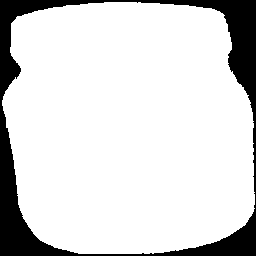
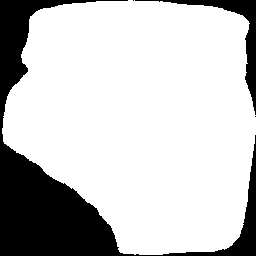
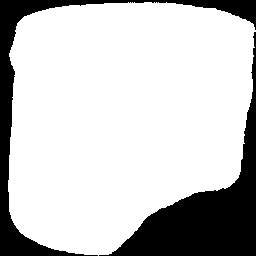
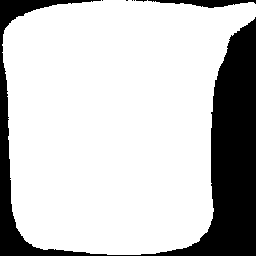
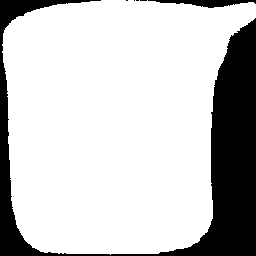
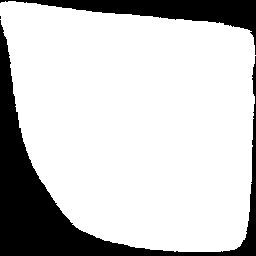
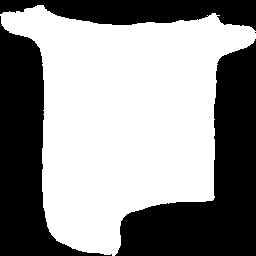
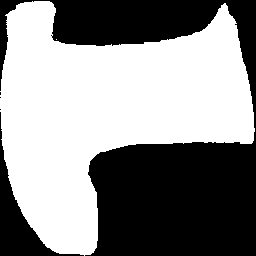
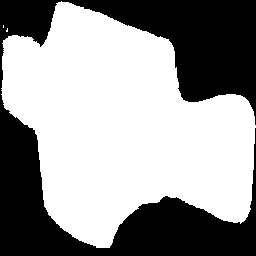
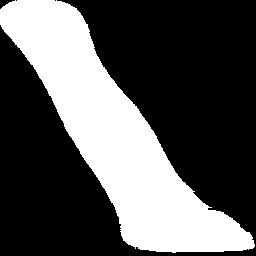
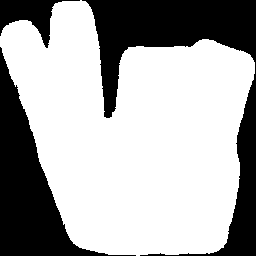
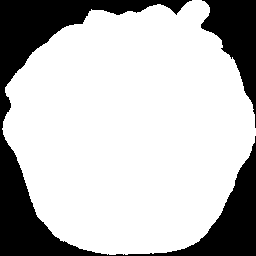
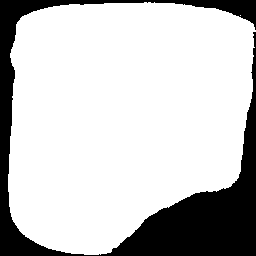
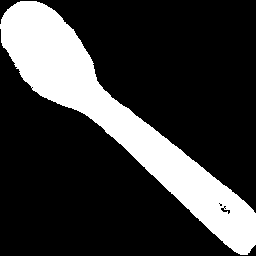
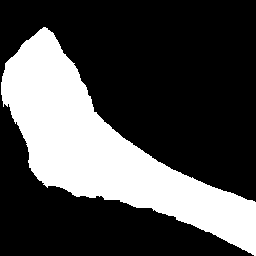

In [ ]:
image = "Cupcakes.jpg" # @param ["Socks.jpg","Vegetables.jpg","Japanese_bento.png","Cupcakes.jpg","Origamis.jpg","Fruits.jpg","Cat.jpg","Pumpkins.jpg","Breakfast.jpg","Bookshelf.jpg", "Spill.jpg"] {"allow-input":true}
prompt = "Give the segmentation masks for the metal, wooden and glass small items (ignore the table). Output a JSON list of segmentation masks where each entry contains the 2D bounding box in the key \"box_2d\", the segmentation mask in key \"mask\", and the text label in the key \"label\". Use descriptive labels."  # @param {type:"string"}

# Load and resize image
im = Image.open(BytesIO(open(image, "rb").read()))
im.thumbnail([1024,1024], Image.Resampling.LANCZOS)

# Run model to find segmentation masks
response = client.models.generate_content(
    model=model_name,
    contents=[prompt, im],
    config = types.GenerateContentConfig(
        temperature=0.5,
        safety_settings=safety_settings,
        thinking_config=types.ThinkingConfig(
          thinking_budget=0
        )
    )
)

# Check output
print(response.text)

The model predicts a JSON list, where each item represents a segmentation mask. Each item has a bounding box ("`box_2d`") in the format `[y0, x0, y1, x1]` with normalized coordinates between 0 and 1000, a label ("`label`") that identifies the object, and lastly the segmentation mask inside the bounding box, as base64 encoded png.

To use the mask, first you need to do base64 decoding, and then loading this string as a png. This will give you a probability map with values between 0 and 255. The mask needs to be resized to match the bounding box dimensions, then you can apply your confidence threshold, e.g. binarizing at 127 for the midpoint. Finally, pad the mask into an array of the size of the full image.

All these steps are done by the the `parse_segmentation_masks` function provided earlier.

Ultimately, use the `plot_segmentation_masks` function to visualize the decoded masks by overlaying it on the image.

In [ ]:
segmentation_masks = parse_segmentation_masks(response.text, img_height=im.size[1], img_width=im.size[0])

In [ ]:
plot_segmentation_masks(im, segmentation_masks)

Output hidden; open in https://colab.research.google.com to view.

## Preliminary capabilities: pointing and 3D boxes

Pointing and 3D bounding boxes are experimental model capabilities. Check this [other notebook](../examples/Spatial_understanding_3d.ipynb) to get a sneak peek on those upcoming capabilities.

<a href="../examples/Spatial_understanding_3d.ipynb"><img src="https://storage.googleapis.com/generativeai-downloads/images/box_3d.png" height="400"/></a>

## What's next?

For a more end-to-end example, the code from the [AI Studio Spatial understanding example](https://aistudio.google.com/starter-apps/spatial)  is available on [Github](https://github.com/google-gemini/starter-applets/tree/main/spatial).

You'll also find multiple other examples of Gemini apabilities in the [quickstart folder](https://github.com/google-gemini/cookbook/tree/main/quickstarts/), in particular the [Live API](./Get_started_LiveAPI.ipynb) and the [video understanding](./Video_understanding.ipynb) one.

Related to image recognition and reasoning, [Market a jet backpack](../examples/Market_a_Jet_Backpack.ipynb) and [Guess the shape](../examples/Guess_the_shape.ipynb) examples are worth checking to continue your Gemini API discovery (Note: these examples still use the old SDK). And of course the [pointing and 3d boxes](../examples/Spatial_understanding_3d.ipynb) example referenced earlier.